# Телекоммуникации

### Классификация абонентов

<div class="alert alert-block alert-info">

Провайдеру интернет и телефонии требуется уменьшить отток клиентов. Для бонусной политики требуется предсказать риски ухода абонентов.\
Команда оператора предоставила данные по заключённым договорам, персональные данные и информацию о предоставляемых услугах.\
На основании этих данных требуется предсказать уход клиента.

В работе я проверила и подготовила данные, провела их исследование, обучила модели, оценила качество предсказаний и дала рекомендации бизнесу.

In [1]:
try:
    from lightgbm import LGBMClassifier
except:
    !pip install lightgbm -q
    from lightgbm import LGBMClassifier
try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade numpy==1.22 -q
    import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
try:
    import phik
except:
    !pip install phik -q
    import phik
from scipy.stats import uniform
import seaborn as sb
try:
    import shap
except:
    !pip install shap -q
    import shap
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder
import winsound

In [2]:
RAND=50824

## Загрузка и предобработка данных

In [3]:
def load(file):
    path='/datasets/'+file
    if not os.path.exists(path):
        path='..\\df\\'+file
    if os.path.exists(path):
        df=pd.read_csv(path)
        print('\n',file)
        display(df.head())
        df.info()
        print('Число дубликатов: ', df.duplicated().sum())
        print('Число повторов id: ', df['customerID'].duplicated().sum())
        return df  
    else:      
        print('Файл не найден')

In [4]:
def unique(df):
    for col in df.select_dtypes(include='object').columns:
        print(col)
        display(df[col].unique())

In [5]:
def sound():
    winsound.Beep(550,1000)

In [6]:
contract=load('contract_new.csv')
person=load('personal_new.csv')
internet=load('internet_new.csv')
phone=load('phone_new.csv')


 contract_new.csv


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Число дубликатов:  0
Число повторов id:  0

 personal_new.csv


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Число дубликатов:  0
Число повторов id:  0

 internet_new.csv


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Число дубликатов:  0
Число повторов id:  0

 phone_new.csv


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Число дубликатов:  0
Число повторов id:  0


Дубликаты и пропуски в базах отсутствуют. Повторов id в базах нет.\
Количество контрактов равно количеству записей в персональных данных. Записей в таблицах услуг интернет и телефонии меньше. Предоставленных услуг телефонии больше.\
Проверю насколько соответствуют id в разных базах, приведу названия к стилю нижнего регистра с подчёркиваниями.\
Проведу парсинг дат, проверю на неявные дубликаты.

In [7]:
contract.columns=['id','begin','end','payed_years','e_billing','payment_method','month_charges','total_charges']
contract.head(1)

,id,begin,end,payed_years,e_billing,payment_method,month_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [8]:
contract['begin']=pd.to_datetime(contract['begin'])
contract.sample(5)

,id,begin,end,payed_years,e_billing,payment_method,month_charges,total_charges
1434,1571-SAVHK,2018-10-01,No,Month-to-month,Yes,Mailed check,99.95,1631.18
2490,7641-TQFHN,2016-11-01,No,Two year,No,Mailed check,100.55,4313.6
3520,6036-TTFYU,2018-10-01,No,Month-to-month,No,Mailed check,19.60,313.6
3818,8819-ZBYNA,2015-04-01,2018-12-01,Two year,Yes,Credit card (automatic),109.10,4800.4
3753,1816-FLZDK,2020-01-01,No,Month-to-month,No,Mailed check,29.15,29.15


In [9]:
contract.begin.describe(datetime_is_numeric=True)[['min','max']]

min    2013-10-01 00:00:00
max    2020-02-01 00:00:00
Name: begin, dtype: object

Договоры заключалсь с октября 2013 по февраль 2020.

In [10]:
contract.begin.apply(lambda x:x.date().day).unique()

array([1], dtype=int64)

In [11]:
sorted(contract.end.unique(),reverse=True)

['No',
 '2020-01-01',
 '2019-12-01',
 '2019-11-01',
 '2019-10-01',
 '2019-09-01',
 '2019-08-01',
 '2019-07-01',
 '2019-06-01',
 '2019-05-01',
 '2019-04-01',
 '2019-03-01',
 '2019-02-01',
 '2019-01-01',
 '2018-12-01',
 '2018-11-01',
 '2018-10-01',
 '2018-09-01',
 '2018-08-01',
 '2018-07-01',
 '2018-06-01',
 '2018-05-01',
 '2018-04-01',
 '2018-03-01',
 '2018-02-01',
 '2018-01-01',
 '2017-12-01',
 '2017-11-01',
 '2017-10-01',
 '2017-09-01',
 '2017-08-01',
 '2017-07-01',
 '2017-06-01',
 '2017-05-01',
 '2017-04-01',
 '2017-03-01',
 '2017-02-01',
 '2017-01-01',
 '2016-12-01',
 '2016-11-01',
 '2016-10-01',
 '2016-09-01',
 '2016-08-01',
 '2016-07-01',
 '2016-06-01',
 '2016-05-01',
 '2016-04-01',
 '2016-03-01',
 '2016-02-01',
 '2016-01-01',
 '2015-12-01',
 '2015-11-01',
 '2015-10-01',
 '2015-09-01',
 '2015-08-01',
 '2015-07-01',
 '2015-06-01',
 '2015-05-01',
 '2015-04-01',
 '2015-03-01',
 '2015-02-01',
 '2015-01-01',
 '2014-12-01',
 '2014-11-01',
 '2014-10-01',
 '2014-09-01',
 '2014-06-01']

Даты округлены до месяца.

In [12]:
contract.end.value_counts(normalize=True)

No            0.843675
2020-01-01    0.005537
2019-12-01    0.005395
2018-11-01    0.004969
2019-09-01    0.004544
                ...   
2014-12-01    0.000284
2014-09-01    0.000284
2014-11-01    0.000142
2014-10-01    0.000142
2014-06-01    0.000142
Name: end, Length: 67, dtype: float64

<div class="alert alert-block alert-info">
Все даты окончания договоров - до даты выгрузки. Есть либо законченные контракты, либо длящиеся. В данном столбце нам важен факт окончания отношений. Выведем отсюда целевой признак: разорвал договор или нет. Заменю данные в этом столбце на бинарные.
    
Замечу, что присутствует дисбаланс классов: 84% продолжают оставаться клинтами компании.\
Данные из окончания договора и начала сведу в один признак: количества дней обслуживания.

In [13]:
contract['finish']=contract.end!='No'
contract['end']=contract['end'].apply(lambda x:'2020-02-01' if x=='No' else x)

In [14]:
contract['days']=((pd.to_datetime(contract.end)-contract.begin)/np.timedelta64(1,'D')).astype('int')

In [15]:
contract.head()

,id,begin,end,payed_years,e_billing,payment_method,month_charges,total_charges,finish,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,False,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,False,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,False,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,False,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,False,153


In [16]:
contract.drop(columns=['end','begin'],inplace=True)

In [17]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              7043 non-null   object 
 1   payed_years     7043 non-null   object 
 2   e_billing       7043 non-null   object 
 3   payment_method  7043 non-null   object 
 4   month_charges   7043 non-null   float64
 5   total_charges   7043 non-null   object 
 6   finish          7043 non-null   bool   
 7   days            7043 non-null   int32  
dtypes: bool(1), float64(1), int32(1), object(5)
memory usage: 364.7+ KB


In [18]:
person.columns=['id','gender','senior','partner','dependents']
person.head(1)

,id,gender,senior,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


In [19]:
internet.columns=['id','service','online_security','cloud','antivirus','support','TV','movies']
internet.head(1)

,id,service,online_security,cloud,antivirus,support,TV,movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [20]:
phone.columns=['id','multy']
phone.head(1)

,id,multy
0,5575-GNVDE,No


In [21]:
set(contract.id)==set(person.id)

True

Набор пользователей в базе договоров соответствует набору - в базе персональных данных.

In [22]:
set(internet.id)<set(contract.id)

True

In [23]:
set(phone.id)<set(contract.id)

True

Все абоненты из баз услуг представлены в общих базах.

In [24]:
contract.set_index('id',inplace=True)
person.set_index('id',inplace=True)
internet.set_index('id',inplace=True)
phone.set_index('id',inplace=True)

In [25]:
unique(contract)

payed_years


array(['Month-to-month', 'One year', 'Two year'], dtype=object)

e_billing


array(['Yes', 'No'], dtype=object)

payment_method


array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

total_charges


array(['31.04', '2071.84', '226.17', ..., '325.6', '520.8', '7251.82'],
      dtype=object)

<div class="alert alert-block alert-info">
    
`e_billing` заменю на логический.
    
`total_charges` имеет тип float.

In [26]:
rang=['Month-to-month', 'One year', 'Two year']# задаю порядок ранговому признаку

In [27]:
contract.e_billing=contract.e_billing=='Yes'

In [28]:
contract.total_charges=pd.to_numeric(contract.total_charges,errors='coerce')

In [29]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   payed_years     7043 non-null   object 
 1   e_billing       7043 non-null   bool   
 2   payment_method  7043 non-null   object 
 3   month_charges   7043 non-null   float64
 4   total_charges   7032 non-null   float64
 5   finish          7043 non-null   bool   
 6   days            7043 non-null   int32  
dtypes: bool(2), float64(2), int32(1), object(2)
memory usage: 316.4+ KB


Появилось 11 пропусков в общих платежах.

In [30]:
contract.query('total_charges.isna()')

,payed_years,e_billing,payment_method,month_charges,total_charges,finish,days
id,,,,,,,
4472-LVYGI,Two year,True,Bank transfer (automatic),52.55,NaN,False,0
3115-CZMZD,Two year,False,Mailed check,20.25,NaN,False,0
5709-LVOEQ,Two year,False,Mailed check,80.85,NaN,False,0
4367-NUYAO,Two year,False,Mailed check,25.75,NaN,False,0
1371-DWPAZ,Two year,False,Credit card (automatic),56.05,NaN,False,0
7644-OMVMY,Two year,False,Mailed check,19.85,NaN,False,0
3213-VVOLG,Two year,False,Mailed check,25.35,NaN,False,0
2520-SGTTA,Two year,False,Mailed check,20.00,NaN,False,0
2923-ARZLG,One year,True,Mailed check,19.70,NaN,False,0


Все договоры с пропусками в общих платежах заключены в день выгрузки. Вероятно, платежи ещё не поступили. Заменю на ноль.

In [31]:
contract.total_charges.fillna(0,inplace=True)

In [32]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   payed_years     7043 non-null   object 
 1   e_billing       7043 non-null   bool   
 2   payment_method  7043 non-null   object 
 3   month_charges   7043 non-null   float64
 4   total_charges   7043 non-null   float64
 5   finish          7043 non-null   bool   
 6   days            7043 non-null   int32  
dtypes: bool(2), float64(2), int32(1), object(2)
memory usage: 316.4+ KB


In [33]:
unique(person)

gender


array(['Female', 'Male'], dtype=object)

partner


array(['Yes', 'No'], dtype=object)

dependents


array(['No', 'Yes'], dtype=object)

In [34]:
person['male']=person.gender=='Male'
person['has_partner']=person.partner=='Yes'
person['has_dependents']=person.dependents=='Yes'
person.drop(columns=['gender','partner','dependents'],inplace=True)

In [35]:
person.senior.unique()

array([0, 1], dtype=int64)

In [36]:
person['senior']=person.senior==1

In [37]:
person.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   senior          7043 non-null   bool 
 1   male            7043 non-null   bool 
 2   has_partner     7043 non-null   bool 
 3   has_dependents  7043 non-null   bool 
dtypes: bool(4)
memory usage: 82.5+ KB


In [38]:
unique(internet)

service


array(['DSL', 'Fiber optic'], dtype=object)

online_security


array(['No', 'Yes'], dtype=object)

cloud


array(['Yes', 'No'], dtype=object)

antivirus


array(['No', 'Yes'], dtype=object)

support


array(['No', 'Yes'], dtype=object)

TV


array(['No', 'Yes'], dtype=object)

movies


array(['No', 'Yes'], dtype=object)

In [39]:
for col in ['online_security', 'cloud', 'antivirus', 'support', 'TV',
       'movies']:
    internet[col]=internet[col]=='Yes'

In [40]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   service          5517 non-null   object
 1   online_security  5517 non-null   bool  
 2   cloud            5517 non-null   bool  
 3   antivirus        5517 non-null   bool  
 4   support          5517 non-null   bool  
 5   TV               5517 non-null   bool  
 6   movies           5517 non-null   bool  
dtypes: bool(6), object(1)
memory usage: 118.5+ KB


In [41]:
unique(phone)

multy


array(['No', 'Yes'], dtype=object)

In [42]:
phone['multy']=phone.multy=='Yes'

In [43]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   multy   6361 non-null   bool 
dtypes: bool(1)
memory usage: 55.9+ KB


## Объединение данных

In [44]:
len(internet)/len(contract)*100

78.33309669175067

In [45]:
len(phone)/len(contract)*100

90.31662643759762

80% пользователей предоставлялись услуги интернета и 90% - телефонии. Значит, 70% - обе услуги.

In [46]:
df=contract.join([person,internet,phone],how='outer')

In [47]:
df.head()

,payed_years,e_billing,payment_method,month_charges,total_charges,finish,days,senior,male,has_partner,has_dependents,service,online_security,cloud,antivirus,support,TV,movies,multy
id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,True,Electronic check,29.85,31.04,False,31,False,False,True,False,DSL,False,True,False,False,False,False,NaN
5575-GNVDE,One year,False,Mailed check,56.95,2071.84,False,1036,False,True,False,False,DSL,True,False,True,False,False,False,False
3668-QPYBK,Month-to-month,True,Mailed check,53.85,226.17,False,123,False,True,False,False,DSL,True,True,False,False,False,False,False
7795-CFOCW,One year,False,Bank transfer (automatic),42.30,1960.60,False,1371,False,True,False,False,DSL,True,False,True,True,False,False,NaN
9237-HQITU,Month-to-month,True,Electronic check,70.70,353.50,False,153,False,False,False,False,Fiber optic,False,False,False,False,False,False,False


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payed_years      7043 non-null   object 
 1   e_billing        7043 non-null   bool   
 2   payment_method   7043 non-null   object 
 3   month_charges    7043 non-null   float64
 4   total_charges    7043 non-null   float64
 5   finish           7043 non-null   bool   
 6   days             7043 non-null   int32  
 7   senior           7043 non-null   bool   
 8   male             7043 non-null   bool   
 9   has_partner      7043 non-null   bool   
 10  has_dependents   7043 non-null   bool   
 11  service          5517 non-null   object 
 12  online_security  5517 non-null   object 
 13  cloud            5517 non-null   object 
 14  antivirus        5517 non-null   object 
 15  support          5517 non-null   object 
 16  TV               5517 non-null   object 
 17  movi

После объединения появились пропуски в тех id, где не было какой-либо услуги. Заполню пропуски в логичеcких признаках отрицанием наличия услуги.\
В признаке типа подключения  проставлю значение No.

In [49]:
df.service.fillna('No',inplace=True)
df=df.fillna(False)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payed_years      7043 non-null   object 
 1   e_billing        7043 non-null   bool   
 2   payment_method   7043 non-null   object 
 3   month_charges    7043 non-null   float64
 4   total_charges    7043 non-null   float64
 5   finish           7043 non-null   bool   
 6   days             7043 non-null   int32  
 7   senior           7043 non-null   bool   
 8   male             7043 non-null   bool   
 9   has_partner      7043 non-null   bool   
 10  has_dependents   7043 non-null   bool   
 11  service          7043 non-null   object 
 12  online_security  7043 non-null   bool   
 13  cloud            7043 non-null   bool   
 14  antivirus        7043 non-null   bool   
 15  support          7043 non-null   bool   
 16  TV               7043 non-null   bool   
 17  movi

### Выводы

<div class="alert alert-info">


- Нам даны четыре небольшие базы размерами до 10 тыс. записей и с количеством признаков до 8.
- Дубликаты и пропуски в базах отсутствуют.
- Повторов id в базах нет. 
Количество контрактов равно количеству записей в персональных данных.
- Предоставленных услуг телефонии больше, чем интернета.
- Договоры заключались с октября 2013 по февраль 2020. Расторгались с июня 2014 по январь 2020. Даты округлены до первых чисел месяцев.
- Все даты окончания договоров - до даты выгрузки. Есть либо законченные контракты, либо длящиеся. На основе признака окончания договора получен целевой бинарный признак расторжения контракта.
- Присутствует дисбаланс классов: 84% продолжают оставаться клинтами компании.
- Добавлен дополнительный признак: прошедшее количество дней договора. Удален признак даты заключения договора.
- Все договоры с пропусками в общих платежах заключены в день выгрузки. Вероятно, платежи ещё не поступили. Пропуски заменены нулём.
- 80% пользователей предоставлялись услуги интернета и 90% - телефонии. Значит, 70% - обе услуги.
- Таблицы сведены в единую базу. Пропуски заполнены отсутствием услуги.

## Исследовательский анализ данных

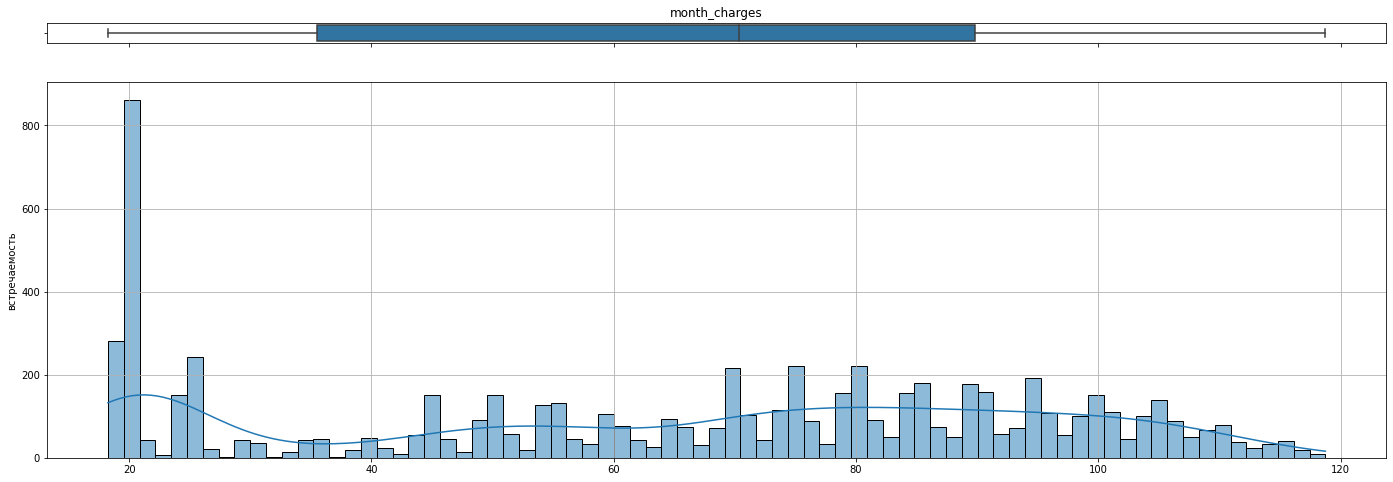

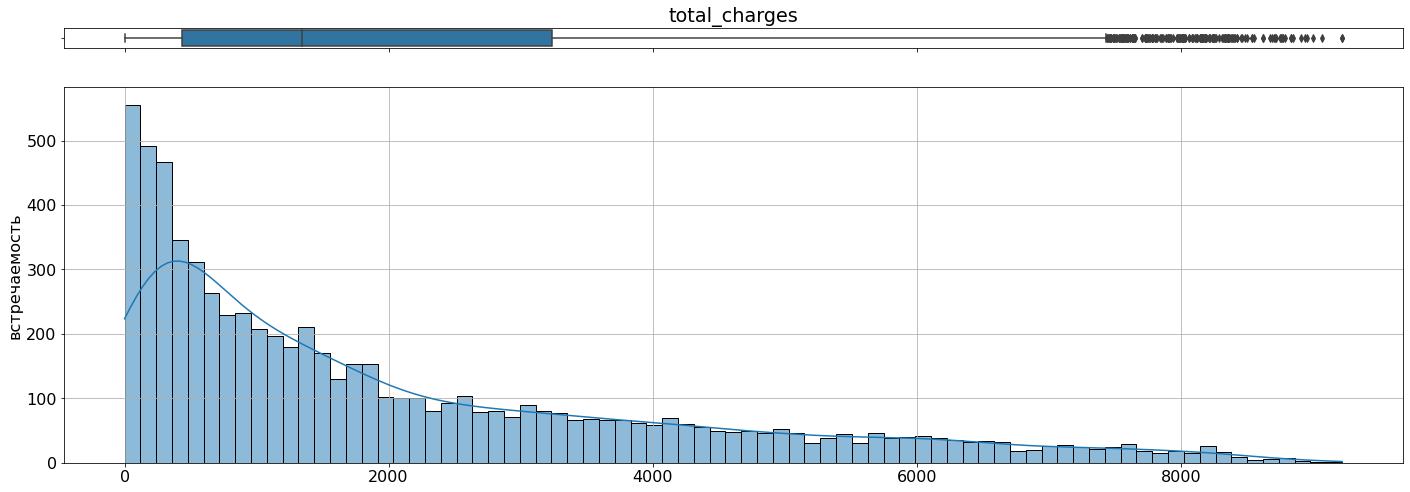

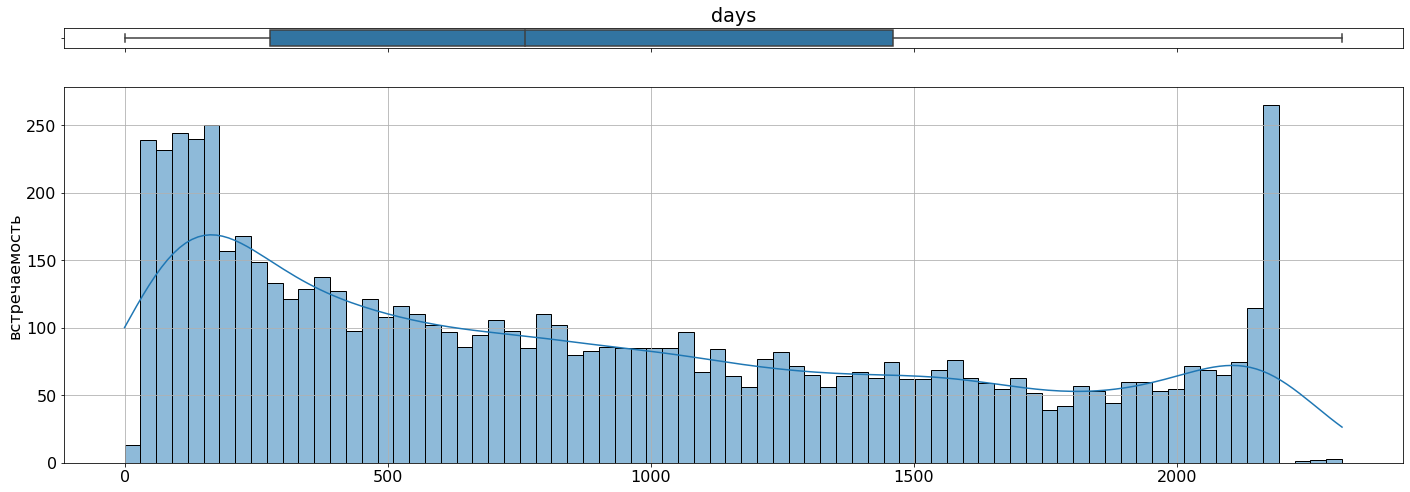

In [51]:
num=['month_charges','total_charges','days']
for col in num:
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex = True,
                                         gridspec_kw = {'height_ratios': (.05,.95)},
                                         figsize=(24,8)) 
     
    sb.boxplot(x = df[col], ax = ax_box)
    sb.histplot(x = df[col], ax = ax_hist, bins = 77, kde = True) 
    ax_box.set_title(col)
    ax_box.set(xlabel='')
    ax_hist.set(xlabel = '', ylabel = "встречаемость")
    plt.rc('font', size=16)
    plt.grid();

In [52]:
df.month_charges.min()

18.25

In [53]:
df.query('total_charges>7500')['finish'].count()/df.finish.count()*100

2.569927587675706

В месячных платежах выбросов нет. Значения от 18 до 120. Распределены бимодальны. Вероятно, по причине разных услуг связи: телефония или интернет.

Общие расходы абонента распределены нормально с пиком на 500, выбросных значений - больше 7500 - 3%, вписаны в нормальное распределение. Cохраню данные.

В распределении длительности бимодальности на 4-месячных договорах и контрактах почти на протяжении всего 6-летнего срока.

In [54]:
nom=df.select_dtypes(include=['object','bool']).columns.to_list()
nom.remove('payment_method')
len(nom)

15

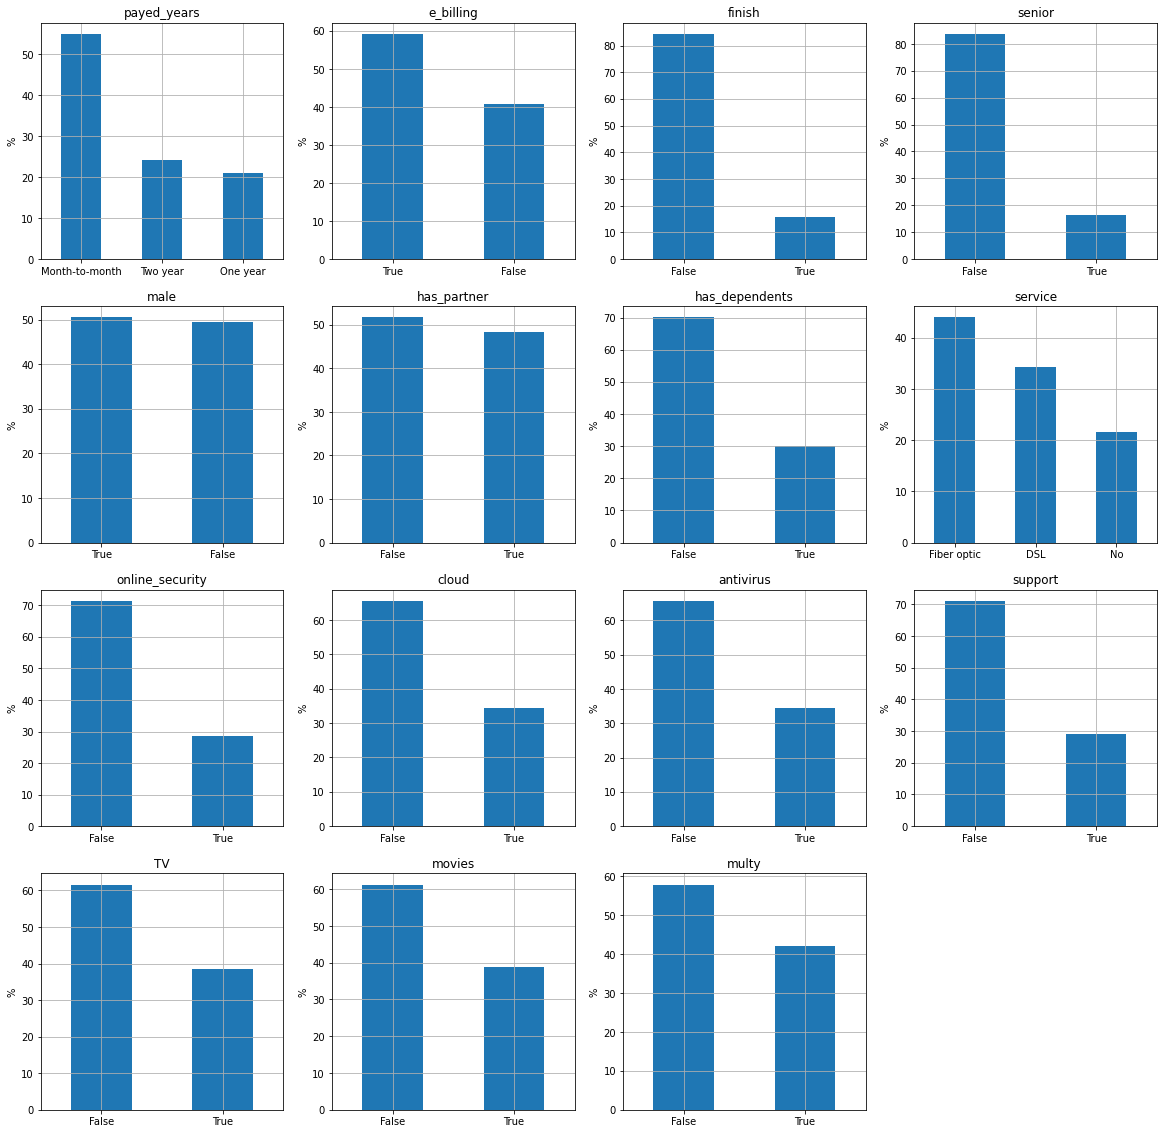

In [55]:
i=1
fig=plt.figure(figsize=(20,20))
plt.rc('font', size=10)
for col in nom:
    ax=fig.add_subplot(4,4,i)
    (df[col].value_counts(normalize=True)*100).plot.bar(title=col,ax=ax,rot=0)
    i+=1
    plt.ylabel('%')
    plt.grid()
plt.show();

16% ушли от оператора,\
16% пенсионеры,\
поровну распределение мужчин и женщин,\
поровну в браке и нет, \
дети - у 30%,\
больше 40% получают услуги связи через оптоволокно,\
треть пользуются дополнительными интернет услугами,\
стриминговым телевидением и каталогом фильмов пользуются 40%,\
у 40% есть подключение телефона к нескольким линиям,\
больше 50% на ежемесячной оплате, по 20% - на одно- и двухлетней.

In [56]:
nom.append('payment_method')

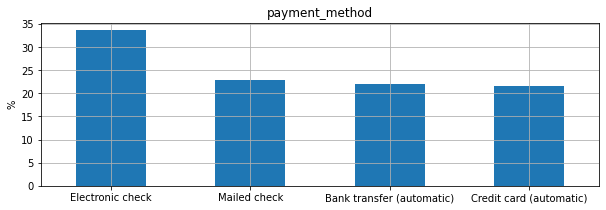

In [57]:
plt.figure(figsize=(10,3))
plt.rc('font', size=10)
(df['payment_method'].value_counts(normalize=True)*100).plot.bar(title='payment_method',rot=0)
plt.ylabel('%')
plt.grid();

У трети электронный чек, остальные способы оплаты распределены равномерно.

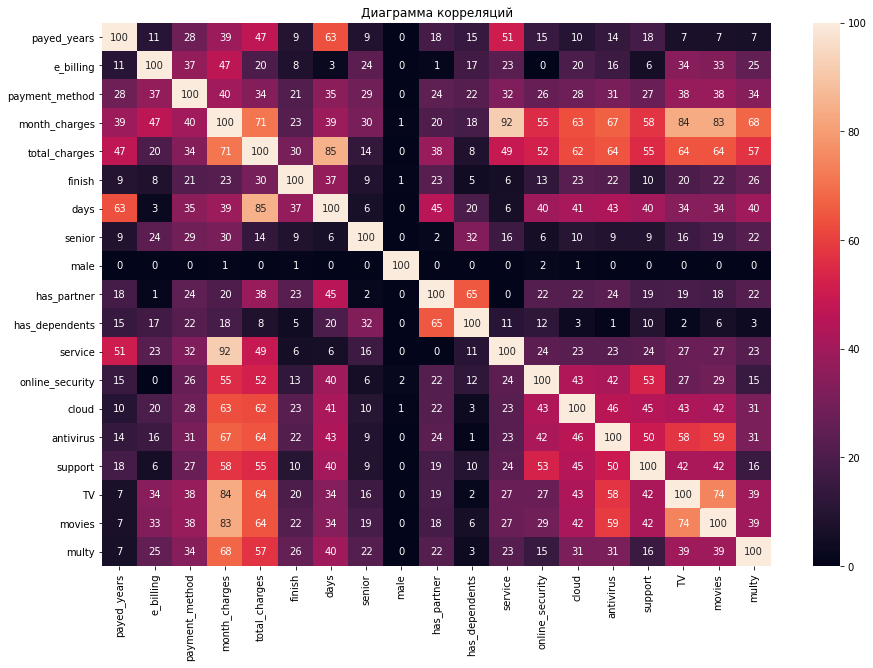

In [58]:
plt.figure(figsize=(15,10))
sb.heatmap((df.phik_matrix(interval_cols=num))*100,annot=True,fmt='.0f')
plt.title('Диаграмма корреляций');

<div class="alert alert-block alert-info">

Мультиколлинеарность между типом подключения и месячным платежом.\
Высокие линейные корреляции между: 
- ожидаемая высокая корреляция между общими тратами абонента и длительностью обслуживания, между тратами и месячным платежом,
- месячным платежом и стриминговым телевидением: видимо, услуга заметно повышает цену,
- месячным платежом и доступом к каталогу фильмов: высокая корреляция между услугами телефидения и каталогом фильмов. 

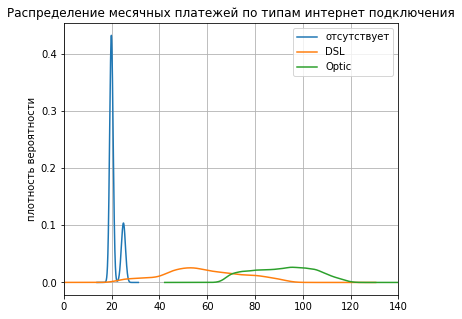

In [59]:
ax=df.query('service=="No"')['month_charges']\
.plot(kind='kde', title='Распределение месячных платежей по типам интернет подключения',label='отсутствует')
df.query('service=="DSL"')['month_charges'].plot(kind='kde',ax=ax,figsize=(6,5),label='DSL')
df.query('service=="Fiber optic"')['month_charges'].plot(kind='kde',ax=ax,label='Optic')
plt.legend(loc='upper right')
plt.ylabel('плотность вероятности')
plt.grid()
plt.xlim(0,140);

Плата за телефон меньше, чем за интернет, а плата за DSL меньше, чем за оптику. Удалю признак типа подключения.

In [60]:
df=df.drop(columns=['service'])

In [61]:
d=df.duplicated().sum()
if d==0:
    print('Дубликатов нет')
else:
    df=df.drop_duplicates()
    print('Удалено полных дубликатов: ',d)    
features=df.drop('finish',1)
index=features[features.duplicated(keep=False)].index
l=len(index)
if l!=0:
    print('Удалено строк с одинаковыми входными признаками и разным значением целевого признака: ', l)
    df=df.drop(index)

Удалено полных дубликатов:  4


### Выводы

<div class="alert alert-block alert-info">
    
- Есть 3% выбросов в общих тратах абонента: значения больше 7500, вписаны в нормальное распределение. Данные сохранены.
- Месячные платежи - от 18 до 120. Распределены бимодальны. Плата за телефон значительно меньше, чем за интернет, и плата за DSL меньше, чем за оптику.
- Уберу мультиколлинеарные признаки для уменьшения числа признаков: из признаков типа подключения и месячного платежа, оставлен второй - у него больше корреляция с целевым признаком и он информативней.
- Общие расходы абонента распределены нормально с пиком на 500.
- Бимодальности на 4-месячных договорах и контрактах почти на протяжении всего 6-летнего срока.
- У целевого признака нет высокой линейной зависимости ни с одним признаком.
- Высокие линейные корреляции между месячным платежом и стриминговым телевидением: услуга заметно повышает цену.
- 16% разорвали контракт,
- 16% пенсионеры,
- поровну распределение мужчин и женщин,
- поровну в браке и нет,
- дети - у 30%,
- больше 40% получают услуги связи через оптоволокно,
- треть пользуются дополнительными интернет услугами,
- стриминговым телевидением и каталогом фильмов пользуются 40%,
- у 40% есть подключение телефона к нескольким линиям,
- больше 50% на ежемесячной оплате, по 20% - на одно- и двухлетней.
- У трети электронный чек, остальные способы оплаты распределены равномерно.

## Подготовка данных 

In [62]:
y=df.finish
X=df.drop(columns='finish')

In [63]:
X_train,X_test,y_train,y_test=train_test_split(X,y, stratify=y,random_state=RAND)

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   payed_years      7039 non-null   object 
 1   e_billing        7039 non-null   bool   
 2   payment_method   7039 non-null   object 
 3   month_charges    7039 non-null   float64
 4   total_charges    7039 non-null   float64
 5   days             7039 non-null   int32  
 6   senior           7039 non-null   bool   
 7   male             7039 non-null   bool   
 8   has_partner      7039 non-null   bool   
 9   has_dependents   7039 non-null   bool   
 10  online_security  7039 non-null   bool   
 11  cloud            7039 non-null   bool   
 12  antivirus        7039 non-null   bool   
 13  support          7039 non-null   bool   
 14  TV               7039 non-null   bool   
 15  movies           7039 non-null   bool   
 16  multy            7039 non-null   bool   
dtypes: b

In [65]:
num

['month_charges', 'total_charges', 'days']

Используемая метрика roc-auc не чувствительна к дисбалансу классов. Достаточно библиотеки sklearn.

<div class="alert alert-block alert-info">

Я буду использовать модели бустинга. Они не требуют масштабирования. Кодирование Ordinal Encoder.

<div class="alert alert-block alert-info">

`month_charges`, `total_charges`, `days` - непрерывные признаки.\
`payment_method` - категориальный.\
`payed_years` - ранговый.
Остальные - бинарные логические не нуждаются в кодировании.

In [66]:
col_prepair=ColumnTransformer(
    [('cat', OrdinalEncoder(),['payment_method']),
    ('rang',OrdinalEncoder(categories=[rang]),['payed_years'])],
    remainder='passthrough')

## Обучение моделей 

In [67]:
pipe=Pipeline([
    ('prepair',col_prepair),
    ('model',GradientBoostingClassifier(random_state=RAND))
])

In [68]:
params=[{'model': [GradientBoostingClassifier(random_state=RAND)],
        'model__max_depth': [None] + [i for i in range(2, 10)],
        'model__learning_rate':uniform(0.1, 0.9),
        'model__min_samples_leaf': range(1, 10),
        'model__min_samples_split': range(2, 10),
        'model__max_leaf_nodes':range(10,300),
        'model__n_estimators': range(100, 800)
        },
        {'model':[LGBMClassifier(random_state=RAND,n_jobs=-1)],
        'model__learning_rate':uniform(0.1, 0.9),
        'model__max_depth': range(2,10),
        'model__reg_alpha': uniform(0,3),
        'model__num_leaves':range(10,300),
        'model__n_estimators': range(100, 800)
        }]

In [69]:
cols=['mean_test_score','std_test_score','mean_fit_time','mean_score_time','params']
table=pd.DataFrame(columns=cols)

In [70]:
def search(i):
    search=RandomizedSearchCV(pipe,params[i], scoring='roc_auc',n_jobs=-1,random_state=RAND,n_iter=30,error_score='raise',verbose=2)
    search.fit(X_train,y_train)    
    best=pd.DataFrame(search.cv_results_)[cols].sort_values('mean_test_score',ascending=False,ignore_index=True)[:3]
    return search, best

In [71]:
search0, table0=search(0)
search1, table1=search(1)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 826, number of negative: 4453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 5279, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156469 -> initscore=-1.684739
[LightGBM] [Info] Start training from score -1.684739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [72]:
table=pd.concat([table,table0,table1],ignore_index=True)
table=table.sort_values('mean_test_score',ascending=False,ignore_index=True)

In [73]:
table[:3]

,mean_test_score,std_test_score,mean_fit_time,mean_score_time,params
0,0.909115,0.011443,5.540540,0.031469,{'model': GradientBoostingClassifier(random_st...
1,0.905824,0.009141,5.023845,0.030138,{'model': GradientBoostingClassifier(random_st...
2,0.902902,0.009538,3.995964,0.031540,{'model': GradientBoostingClassifier(random_st...


In [74]:
sound()

Возьмём лучшую модель, её оценка лучше остальных.

In [75]:
print("Параметры лучшей модели", search0.best_params_)

Параметры лучшей модели {'model': GradientBoostingClassifier(random_state=50824), 'model__learning_rate': 0.3962414012282678, 'model__max_depth': 4, 'model__max_leaf_nodes': 109, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 263}


In [76]:
search=search0

## Проверка модели

In [77]:
predict=search.predict(X_test)

In [78]:
print('roc-auc:',round(roc_auc_score(y_test,search.predict_proba(X_test)[:,1]),3))
print('accuracy:', round(accuracy_score(y_test,predict),2))
print('recall:', round(recall_score(y_test,predict),2))

roc-auc: 0.905
accuracy: 0.92
recall: 0.59


In [79]:
print("Оценка roc_auc на случайных величинах:",
      roc_auc_score(y_test,DummyClassifier(strategy='stratified',random_state=RAND).fit(X_train,y_train).predict_proba(X_test)[:,1]).round(2))

Оценка roc_auc на случайных величинах: 0.5


Хорошие метрики, но маловата важная для цели исследования метрика recall. Посмотрю, стоит ли менять порог классификации.

In [80]:
probs=search.predict_proba(X_test)[:,1]
accuracies=[]
for i in np.linspace(0.1,0.9):
    accuracies.append(accuracy_score(y_test,np.where(probs>i,1,0)))
recalls=[]
for i in np.linspace(0.1,0.9):
    recalls.append(recall_score(y_test,np.where(probs>i,1,0)))

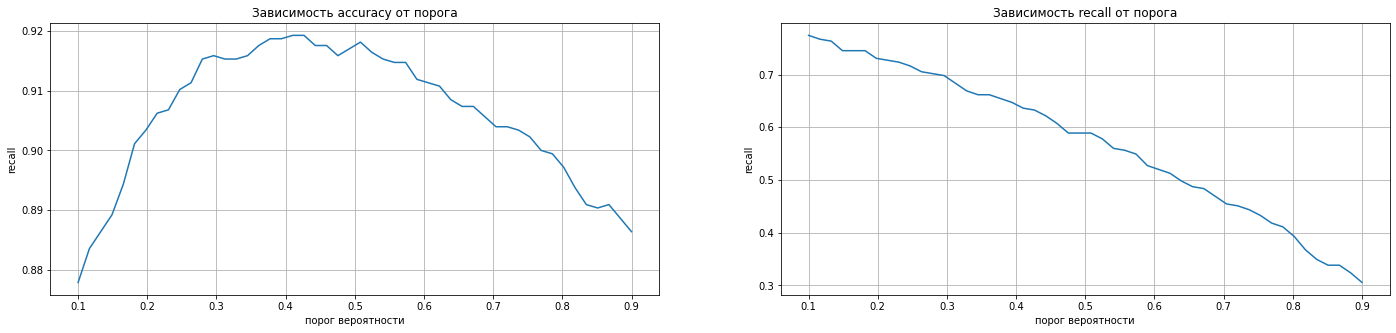

In [81]:
fig=plt.figure(figsize=(24,5))
fig.add_subplot(1,2,1)
plt.plot(np.linspace(0.1,0.9),accuracies)
plt.title('Зависимость accuracy от порога')
plt.xlabel('порог вероятности')
plt.ylabel('recall')
plt.grid()
fig.add_subplot(1,2,2)
plt.plot(np.linspace(0.1,0.9),recalls)
plt.title('Зависимость recall от порога')
plt.xlabel('порог вероятности')
plt.ylabel('recall')
plt.grid();

Максимальная accuracy на 0.4. Рекомендуемый порог для классификации до 0.4.
Recall при 0.4:

In [82]:
best=np.where(probs>0.4,1,0)
recall_score(y_test,best)

0.6472727272727272

Зафиксируем порог на 0.4

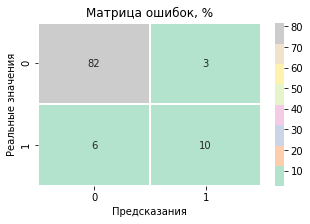

In [83]:
plt.figure(figsize=(5,3))
sb.heatmap(confusion_matrix(y_test,best)/len(y_test)*100,annot=True,cmap='Pastel2',linewidths=1,fmt='.0f')
plt.title('Матрица ошибок, %')
plt.xlabel('Предсказания')
plt.ylabel('Реальные значения')
plt.rc('font', size=10);

<div class="alert alert-block alert-info">

6% значений, являющихся рисками, не найдено и 3% значений оказался ложноположительными предсказаниями. Точность превалирует над охватом. Хотя охват для данной проблемы важнее. Рекомендуется снижать порог классификации.

## Общий вывод и рекомендации заказчику 

Библиотеки загружены и обновлены до необходимых версий . Дополнительно были установлены shap, phik, lightgbm.\
Данные загружены и проведена их первичная обработка. Затем четыре таблицы сведены в единую базу.\
**Результаты подготовительной части:**

<div class="alert alert-info">

- Нам даны четыре небольшие базы размерами до 10 тыс. записей и с количеством признаков до 8.
- Дубликаты и пропуски в базах отсутствуют.
- Повторов id в базах нет. 
Количество контрактов равно количеству записей в персональных данных.
- Предоставленных услуг телефонии больше, чем интернета.
- Договоры заключались с октября 2013 по февраль 2020. Расторгались с июня 2014 по январь 2020. Даты округлены до первых чисел месяцев.
- Все даты окончания договоров - до даты выгрузки. Есть либо законченные контракты, либо длящиеся. На основе признака окончания договора получен целевой бинарный признак расторжения контракта.
- Присутствует дисбаланс классов: 84% продолжают оставаться клинтами компании.
- Добавлен дополнительный признак: прошедшее количество дней договора. Удален признак даты заключения договора.
- Все договоры с пропусками в общих платежах заключены в день выгрузки. Вероятно, платежи ещё не поступили. Пропуски заменены нулём.
- 80% пользователей предоставлялись услуги интернета и 90% - телефонии. Значит, 70% - обе услуги.
- Таблицы сведены в единую базу. Пропуски заполнены отсутствием услуги.

Затем проведено исследование данных на распределение значений и присутствие выбросов.\
**Результаты исследования данных:**

<div class="alert alert-block alert-info">
    
- Есть 3% выбросов в общих тратах абонента: значения больше 7500, вписаны в нормальное распределение. Данные сохранены.
- Месячные платежи - от 18 до 120. Распределены бимодальны. Плата за телефон значительно меньше, чем за интернет, и плата за DSL меньше, чем за оптику.
- Уберу мультиколлинеарные признаки для уменьшения числа признаков: из признаков типа подключения и месячного платежа, оставлен второй - у него больше корреляция с целевым признаком и он информативней.
- Общие расходы абонента распределены нормально с пиком на 500.
- Бимодальности на 4-месячных договорах и контрактах почти на протяжении всего 6-летнего срока.
- У целевого признака нет высокой линейной зависимости ни с одним признаком.
- Высокие линейные корреляции между месячным платежом и стриминговым телевидением: услуга заметно повышает цену.
- 16% разорвали контракт,
- 16% пенсионеры,
- поровну распределение мужчин и женщин,
- поровну в браке и нет,
- дети - у 30%,
- больше 40% получают услуги связи через оптоволокно,
- треть пользуются дополнительными интернет услугами,
- стриминговым телевидением и каталогом фильмов пользуются 40%,
- у 40% есть подключение телефона к нескольким линиям,
- больше 50% на ежемесячной оплате, по 20% - на одно- и двухлетней.
- У трети электронный чек, остальные способы оплаты распределены равномерно.

Рассмотрены две модели древесного градиентного бустинга из библиотек sklearn и lightgbm.\
Сделано кодирование небинарных категориальных значений инструментом OrdinalEncoder, бинарные - переведены в логический тип.\
Выборки разделены в соотношении 3:1 на тренировочную и тестовую с сохранением соотношения значений целевого признака.

In [84]:
print('Непрерывные признаки:', num)

Непрерывные признаки: ['month_charges', 'total_charges', 'days']


Модели и гиперпараметры подбирались методом рандомной кроссвалидации, по 30 итераций на каждую модель. Изменялись размер шага, максимальная глубина, максимальное количество узлов, минимальное количество образцов в листе, минимальное количество образцов для разделения узла, количество деревьев, максимальное количество листьев, коэффициент лассо-регуляризации.\
Получена лучшая модель:

In [85]:
search.best_params_

{'model': GradientBoostingClassifier(random_state=50824),
 'model__learning_rate': 0.3962414012282678,
 'model__max_depth': 4,
 'model__max_leaf_nodes': 109,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 4,
 'model__n_estimators': 263}

<div class="alert alert-block alert-info">

Классификатор GradientBoostingClassifier с повышенной скоростью обучения до 0.4, масимальная глубина увеличина до 4, максимальное количество узлов 109, минимальное количество образцов в листе 1, минимальное количество образцов для разделения узла увеличено до 4, количество деревьев увеличено до 263.

In [86]:
print('со следующими показателями:\n', table.loc[0])

со следующими показателями:
 mean_test_score                                             0.909115
std_test_score                                              0.011443
mean_fit_time                                                5.54054
mean_score_time                                             0.031469
params             {'model': GradientBoostingClassifier(random_st...
Name: 0, dtype: object


In [87]:
print('Оценки на тесте:')
print('roc-auc:',round(roc_auc_score(y_test,search.predict_proba(X_test)[:,1]),3))
print('accuracy:', round(accuracy_score(y_test,predict),2))
print('recall:', round(recall_score(y_test,predict),2))

Оценки на тесте:
roc-auc: 0.905
accuracy: 0.92
recall: 0.59


In [88]:
print('Это лучше случайного предсказания в', round(0.905/0.5,1), 'раз')

Это лучше случайного предсказания в 1.8 раз


<div class="alert alert-block alert-info">

Максимальную эффективность модель показывает при пороге классификации 0.4. Поиск оптимального соотношения точности и охвата нужно искать при пороговых значениях до 0.4.

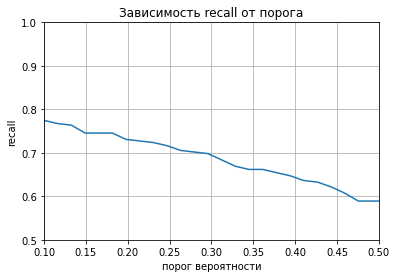

In [89]:
plt.plot(np.linspace(0.1,0.9),recalls)
plt.title('Зависимость recall от порога')
plt.xlabel('порог вероятности')
plt.ylabel('recall')
plt.grid()
plt.xlim(0.1,0.5)
plt.ylim(0.5,1);

<div class="alert alert-block alert-info">

При пороговом значении 0.4 6% значений, являющихся рисками, не найдено и 1% значений оказался ложноположительными предсказаниями. Точность превалирует над охватом. Хотя охват для данной проблемы важнее.

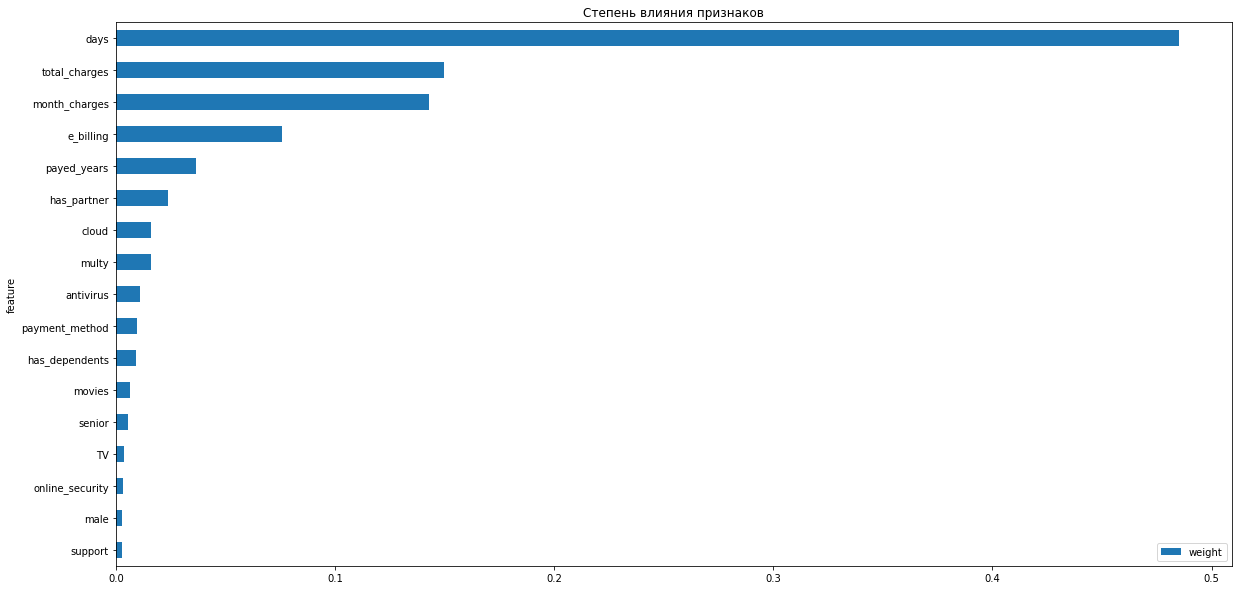

In [90]:
importance=pd.DataFrame([X.columns,search.best_estimator_['model'].feature_importances_]).T
importance.columns=['feature','weight']
importance=importance.sort_values('weight',ignore_index=True)
importance.plot(x='feature',kind='barh',figsize=(20,10),title='Степень влияния признаков');

<div class="alert alert-block alert-info">

customerID: направлен в индексы.\
BeginDate (begin), InternetService(service): удалён.\
EndDate (finish): целевой признак - No -> 0, дата -> 1.\
PaymentMethod: кодирован OrdinalEncoder.\
Type (payed_years): закодирован в порядке - month-to-month, one year, two year.\
PaperlessBilling (e_billing),gender (male),	SeniorCitizen (senior), Partner	(has_partner), Dependents (has_dependents), MultipleLines (multy), OnlineSecurity,	OnlineBackup (cloud),	DeviceProtection (antivirus), TechSupport (support), StreamingTV (TV),	StreamingMovies (movies) - в логический.\
TotalCharges -  пропуски заполнены 0 (оплаты ещё не поступали).\
InternetService (service) - отсутсвие в No.\
Добавлен признак days вычитанием дат: из даты окончания или выгрузки при её отсутствии - даты заключения, и переводом в целочисленный тип.

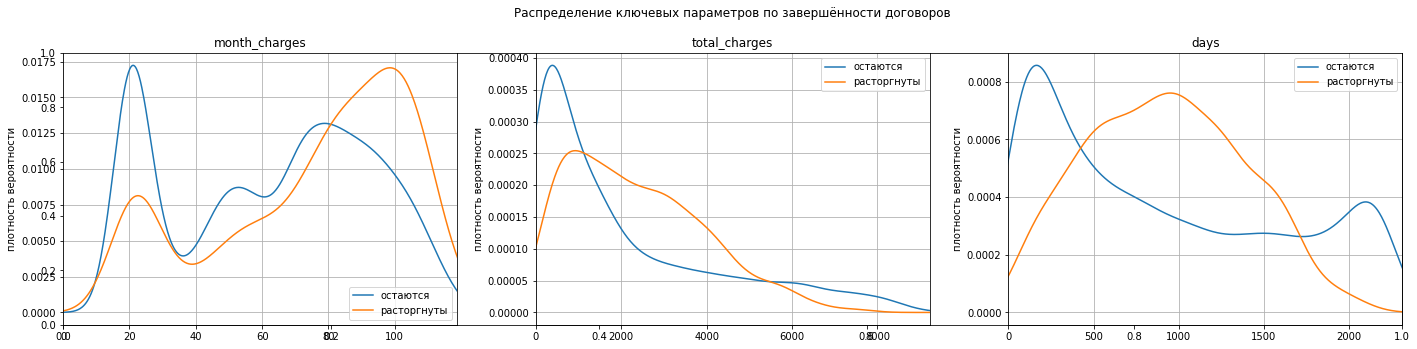

In [91]:
fig=plt.figure(figsize=(24,5))
plt.title('Распределение ключевых параметров по завершённости договоров\n\n')
for i in range(3):
    ax=fig.add_subplot(1,3,i+1)
    df.query('not finish')[num[i]].plot(kind='kde',ax=ax, title=num[i],label='остаются')
    df.query('finish')[num[i]].plot(kind='kde',ax=ax,label='расторгнуты')
    plt.legend(loc='best')
    plt.ylabel('плотность вероятности')
    plt.grid()
    plt.xlim(0,df[num[i]].max())
plt.show();

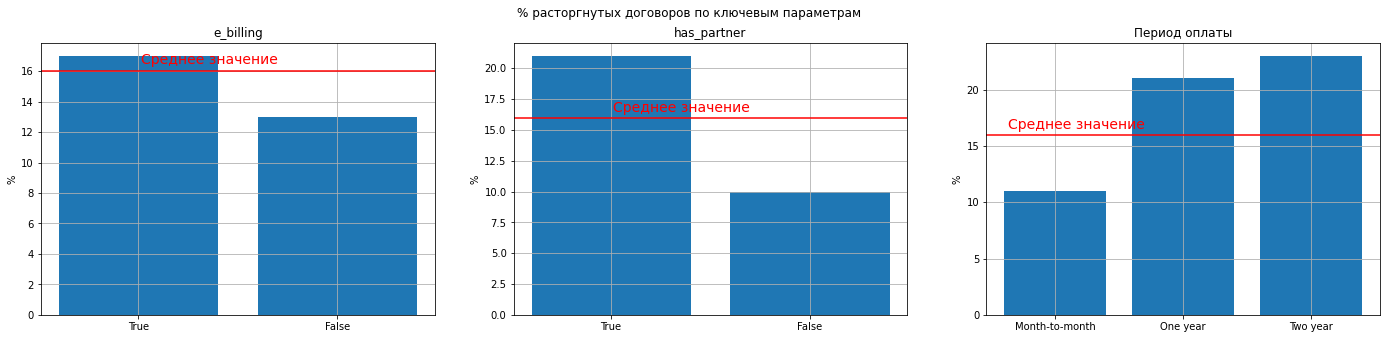

In [92]:
fig=plt.figure(figsize=(24,5))
plt.suptitle('% расторгнутых договоров по ключевым параметрам')
cat=['e_billing','has_partner']
for i in range(2):
    ax=fig.add_subplot(1,3,i+1)
    left=[]
    col=cat[i]
    s=df[df[col]]['finish']
    left.append(int(s.value_counts(normalize=True)[1].round(2)*100))
    s=df[~df[col]]['finish']
    left.append(int(s.value_counts(normalize=True)[1].round(2)*100))
    plt.bar(['True','False'],left)
    plt.grid()
    plt.ylabel('%')
    plt.title(col)
    plt.axhline(y=16, color='r', linestyle='-') 
    plt.text(x=0.7, y=16 + 0.5, s='Среднее значение', color='r', fontsize=14, ha='right')
ax=fig.add_subplot(1,3,3)
left=[]
names=df['payed_years'].unique().tolist()
for n in names:
    s=df[df['payed_years']==n]['finish']
    left.append(int(s.value_counts(normalize=True)[1].round(2)*100))
plt.bar(names,left)
plt.grid()
plt.ylabel('%')
plt.title('Период оплаты')
plt.axhline(y=16, color='r', linestyle='-') 
plt.text(x=0.7, y=16 + 0.5, s='Среднее значение', color='r', fontsize=14, ha='right')
plt.show();

### Рекомендации

<div class="alert alert-block alert-info">

В группе риска абоненты:
- с договорами длительностью 400-1700 дней (1-4.5 года)
- общими тратами 1-5 тыс.
- месячным платежом больше 80
- с наличием элетронного расчётного листа
- с периодами оплаты 1-2 года
- состоящие в браке.

<div class="alert alert-block alert-info">

Для этих категорий абонентов рекомендуема бонусная программа.\
Стоит сдерживать рост тарифов, проверить работу сервиса электронного чека, уменьшить возможность оплат длительными периодами.\
Разработать предложения для семейных пар.